##projet_[AOUIDA WAJIH]

# Test de SMOTE et ADASYN sur des Données Déséquilibrées

Dans ce notebook, nous allons :

- Générer un dataset artificiellement déséquilibré, puis appliquer SMOTE et ADASYN pour rééquilibrer les classes.
- Tester les mêmes approches sur le dataset Titanic ainsi que sur un sous-ensemble déséquilibré de MNIST.
- Évaluer les performances des modèles (Random Forest / Logistic Regression) avant et après rééchantillonnage.
- Visualiser les distributions de classes, les courbes ROC, les matrices de confusion (sous forme de heatmap), etc.
- Discuter des constatations, des performances observées et des moyens d'amélioration (en jouant notamment sur les paramètres` k_neighbors` pour SMOTE/ADASYN et `n_estimators` pour le RandomForest).


In [3]:
#!pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

from tensorflow.keras.datasets import mnist

sns.set(style="whitegrid")


##Données Synthétiques

Objectif :
Créer un jeu de données artificiel déséquilibré, puis comparer les performances d’un modèle avant et après application de SMOTE et ADASYN.




Données :
Nous utilisons make_classification pour créer un dataset avec 2000 échantillons, où environ 10% des données appartiennent à la classe minoritaire.

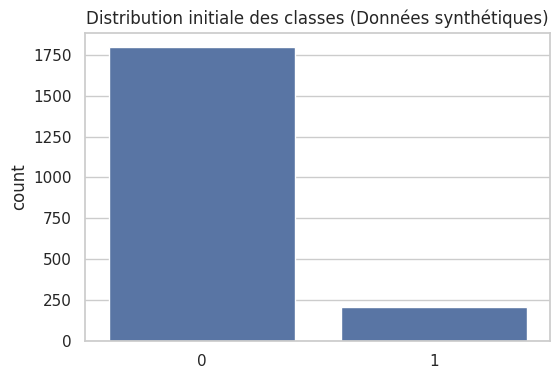

In [18]:
X, y = make_classification(n_samples=2000,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.9, 0.1],
                           class_sep=1.0,
                           random_state=42)

plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribution initiale des classes (Données synthétiques)")
plt.show()


Modèle Sans Rééchantillonnage (Données Synthétiques)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle sans rééchantillonnage
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Performances sans rééchantillonnage:")
print(classification_report(y_test, y_pred))


Performances sans rééchantillonnage:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       449
           1       0.79      0.73      0.76        51

    accuracy                           0.95       500
   macro avg       0.88      0.85      0.86       500
weighted avg       0.95      0.95      0.95       500



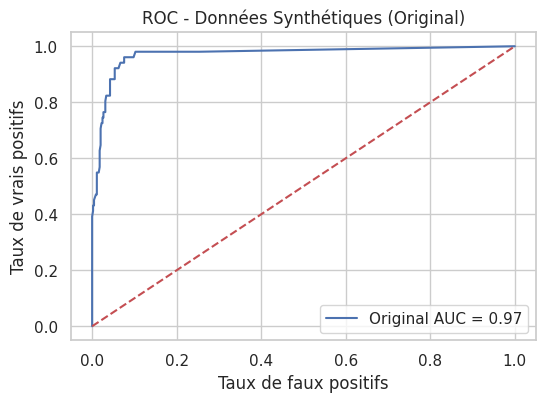

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Original AUC = %.2f' % auc_score)
plt.plot([0,1],[0,1], 'r--')
plt.title("ROC - Données Synthétiques (Original)")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.show()


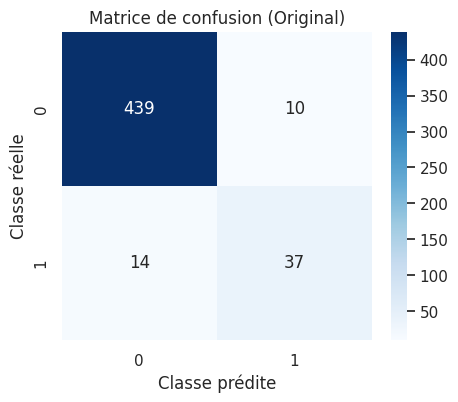

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (Original)")
plt.ylabel("Classe réelle")
plt.xlabel("Classe prédite")
plt.show()


Interprétation :

Le modèle montre une bonne performance globale, comme indiqué par une AUC de 0.97 sur la courbe ROC. Cela traduit une capacité élevée du modèle à distinguer les classes.

Cependant, l’analyse de la matrice de confusion révèle que, bien que le modèle performe bien sur la classe majoritaire (classe 0 avec 439 vraies prédictions positives), il montre une performance relativement faible sur la classe minoritaire (classe 1), avec seulement 37 instances correctement prédites. Ce déséquilibre de performance se reflète dans un rappel plus faible pour la classe minoritaire.

En conclusion, bien que le modèle soit précis dans son ensemble, il présente un biais vers la classe majoritaire.

Application de SMOTE (Données Synthétiques)


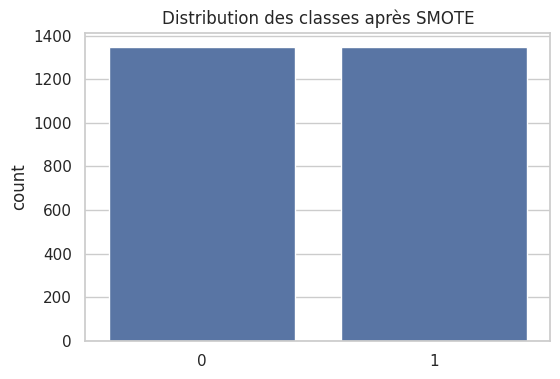

Performances après SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       449
           1       0.69      0.88      0.78        51

    accuracy                           0.95       500
   macro avg       0.84      0.92      0.87       500
weighted avg       0.96      0.95      0.95       500



In [22]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

# Distribution après SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_sm)
plt.title("Distribution des classes après SMOTE")
plt.show()

model_sm = RandomForestClassifier(random_state=42)
model_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_sm.predict(X_test_scaled)

print("Performances après SMOTE:")
print(classification_report(y_test, y_pred_sm))


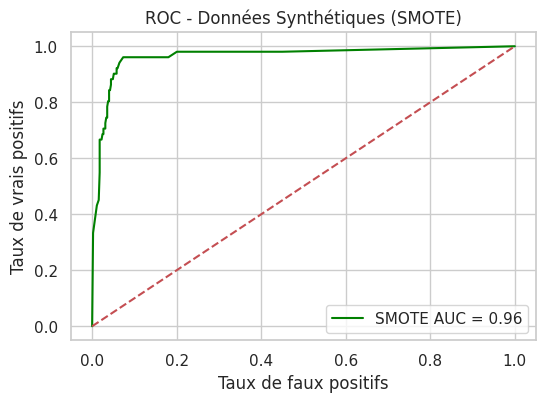

In [23]:
fpr_sm, tpr_sm, _ = roc_curve(y_test, model_sm.predict_proba(X_test_scaled)[:,1])
auc_sm = auc(fpr_sm, tpr_sm)

plt.figure(figsize=(6,4))
plt.plot(fpr_sm, tpr_sm, label='SMOTE AUC = %.2f' % auc_sm, color='green')
plt.plot([0,1],[0,1], 'r--')
plt.title("ROC - Données Synthétiques (SMOTE)")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.show()


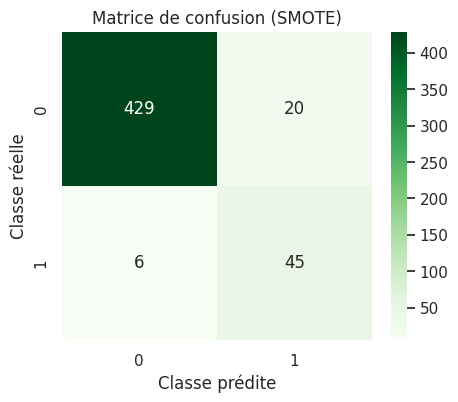

In [24]:
cm_sm = confusion_matrix(y_test, y_pred_sm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sm, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion (SMOTE)")
plt.ylabel("Classe réelle")
plt.xlabel("Classe prédite")
plt.show()


Interprétation :

L’utilisation de SMOTE pour générer des exemples synthétiques de la classe minoritaire a permis d’améliorer la détection de cette dernière. Cela se reflète dans une augmentation du rappel pour la classe 1, avec 45 instances correctement classées contre 37 précédemment. Cette amélioration est également visible dans la réduction du nombre de faux négatifs (6 contre 14 dans le cas initial).

Cependant, cette amélioration sur la classe minoritaire s’accompagne d’une légère augmentation des faux positifs pour la classe majoritaire (20 contre 10 précédemment). Cela peut indiquer un compromis entre les performances sur les deux classes.

En termes globaux, l’AUC reste élevée (0.96), indiquant une capacité continue du modèle à séparer les classes. Cependant, l’impact du SMOTE sur les métriques comme la F1-score, qui équilibre précision et rappel, pourrait être plus révélateur des performances réelles après rééchantillonnage.



Application d’ADASYN (Données Synthétiques)


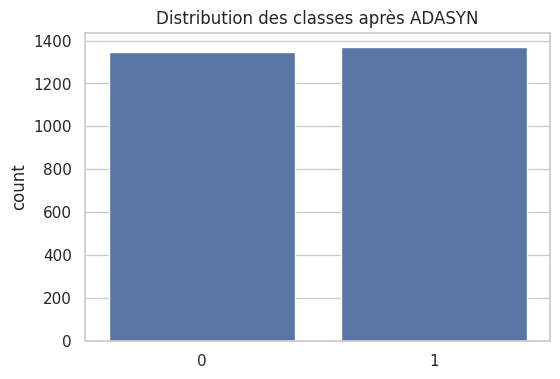

Performances après ADASYN:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       449
           1       0.57      0.86      0.69        51

    accuracy                           0.92       500
   macro avg       0.78      0.89      0.82       500
weighted avg       0.94      0.92      0.93       500



In [25]:
ad = ADASYN(random_state=42)
X_train_ad, y_train_ad = ad.fit_resample(X_train_scaled, y_train)

# Distribution après ADASYN
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_ad)
plt.title("Distribution des classes après ADASYN")
plt.show()

model_ad = RandomForestClassifier(random_state=42)
model_ad.fit(X_train_ad, y_train_ad)
y_pred_ad = model_ad.predict(X_test_scaled)

print("Performances après ADASYN:")
print(classification_report(y_test, y_pred_ad))


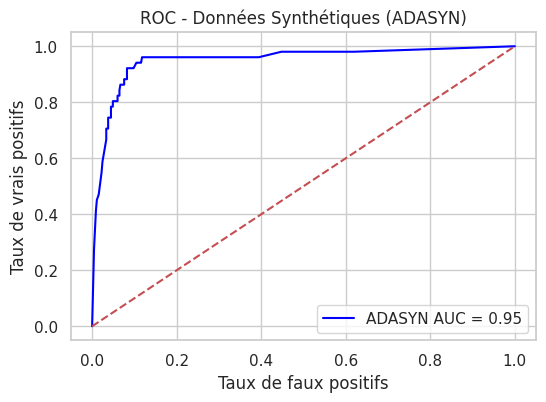

In [26]:
fpr_ad, tpr_ad, _ = roc_curve(y_test, model_ad.predict_proba(X_test_scaled)[:,1])
auc_ad = auc(fpr_ad, tpr_ad)

plt.figure(figsize=(6,4))
plt.plot(fpr_ad, tpr_ad, label='ADASYN AUC = %.2f' % auc_ad, color='blue')
plt.plot([0,1],[0,1], 'r--')
plt.title("ROC - Données Synthétiques (ADASYN)")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.show()


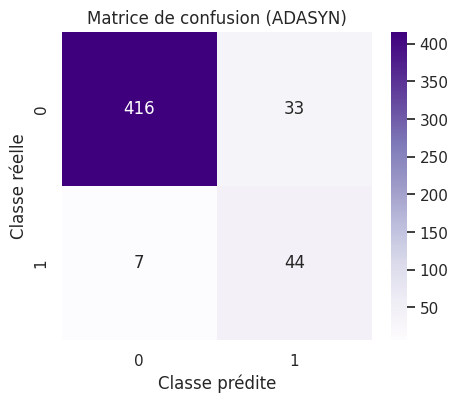

In [27]:
cm_ad = confusion_matrix(y_test, y_pred_ad)
plt.figure(figsize=(5,4))
sns.heatmap(cm_ad, annot=True, fmt='d', cmap='Purples')
plt.title("Matrice de confusion (ADASYN)")
plt.ylabel("Classe réelle")
plt.xlabel("Classe prédite")
plt.show()


Interprétation :

Comme SMOTE, ADASYN vise à améliorer la détection de la classe minoritaire en générant des exemples synthétiques. Cependant, ADASYN se distingue en donnant plus de poids aux zones où les données de la classe minoritaire sont plus difficiles à séparer (zones à faible densité).

Dans ce cas, l’AUC de 0.95 indique une performance légèrement inférieure à celle observée avec SMOTE. Cela peut refléter le fait qu’ADASYN, en se concentrant sur des zones spécifiques, peut introduire davantage de faux positifs pour la classe majoritaire.

L’impact d’ADASYN sur le rappel de la classe minoritaire et les faux positifs de la classe majoritaire nécessite une analyse détaillée à partir de la matrice de confusion et des autres métriques comme la F1-score.







##Application sur le Dataset Titanic

Objectif :
Vérifier si les améliorations observées sur les données synthétiques se reproduisent sur un dataset réel déséquilibré.



<ipython-input-4-88b581e2e973>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
<ipython-input-4-88b581e2e973>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

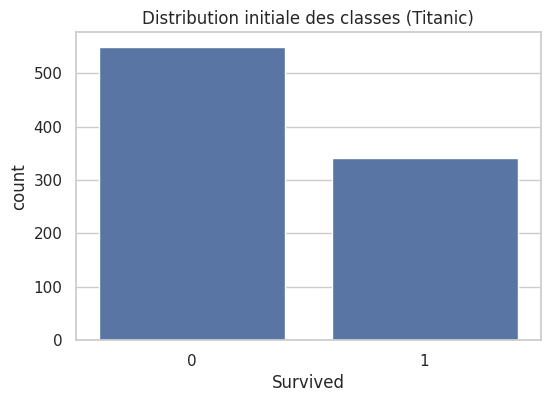

In [4]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(url)


titanic = titanic.drop(['Name','Ticket','Cabin'], axis=1)
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)

titanic['Sex'] = titanic['Sex'].map({'male':0, 'female':1})
titanic = pd.get_dummies(titanic, columns=['Embarked'], drop_first=True)

X_t = titanic.drop('Survived', axis=1)
y_t = titanic['Survived']

plt.figure(figsize=(6,4))
sns.countplot(x=y_t)
plt.title("Distribution initiale des classes (Titanic)")
plt.show()

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, stratify=y_t, random_state=42)

scaler_t = StandardScaler()
X_train_t_scaled = scaler_t.fit_transform(X_train_t)
X_test_t_scaled = scaler_t.transform(X_test_t)


In [5]:
model_t = RandomForestClassifier(random_state=42)
model_t.fit(X_train_t_scaled, y_train_t)
y_pred_t = model_t.predict(X_test_t_scaled)

print("Performances Titanic sans rééchantillonnage:")
print(classification_report(y_test_t, y_pred_t))


Performances Titanic sans rééchantillonnage:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       137
           1       0.79      0.64      0.71        86

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223



In [6]:
X_train_t_sm, y_train_t_sm = SMOTE(random_state=42).fit_resample(X_train_t_scaled, y_train_t)

model_t_sm = RandomForestClassifier(random_state=42)
model_t_sm.fit(X_train_t_sm, y_train_t_sm)
y_pred_t_sm = model_t_sm.predict(X_test_t_scaled)

print("Performances Titanic après SMOTE:")
print(classification_report(y_test_t, y_pred_t_sm))


Performances Titanic après SMOTE:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       137
           1       0.76      0.70      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223



In [7]:
X_train_t_ad, y_train_t_ad = ADASYN(random_state=42).fit_resample(X_train_t_scaled, y_train_t)

model_t_ad = RandomForestClassifier(random_state=42)
model_t_ad.fit(X_train_t_ad, y_train_t_ad)
y_pred_t_ad = model_t_ad.predict(X_test_t_scaled)

print("Performances Titanic après ADASYN:")
print(classification_report(y_test_t, y_pred_t_ad))


Performances Titanic après ADASYN:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       137
           1       0.70      0.69      0.69        86

    accuracy                           0.77       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.77      0.77      0.77       223



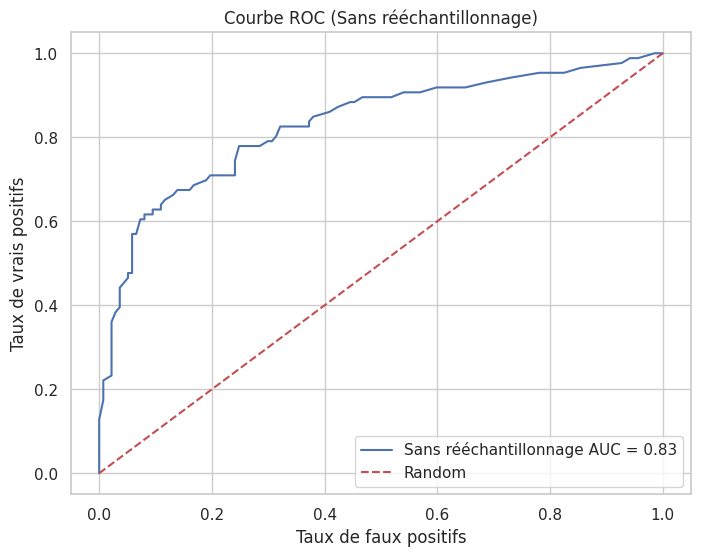

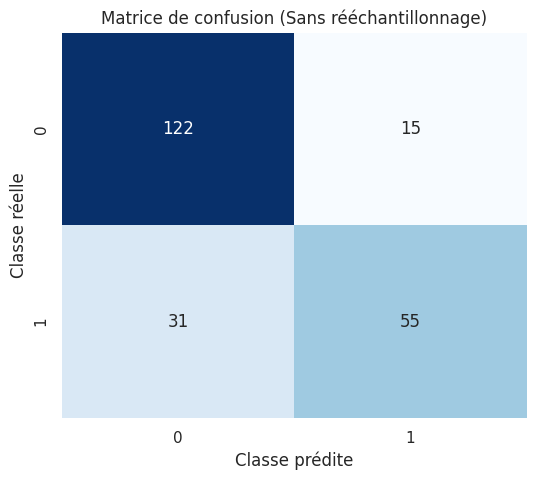

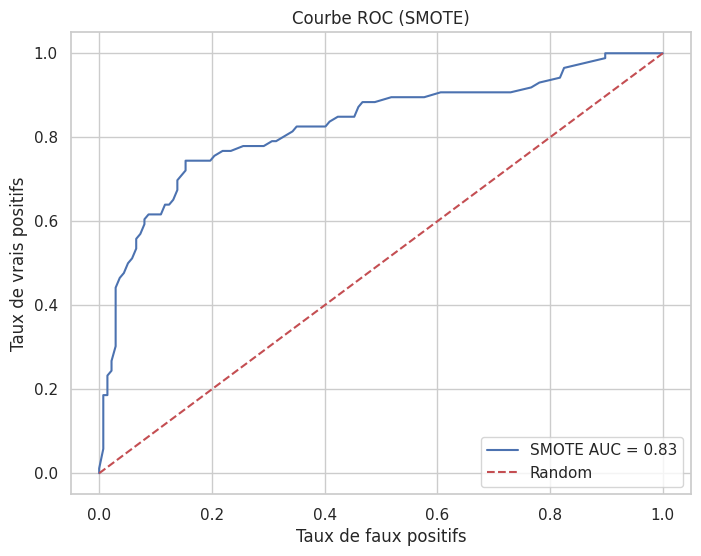

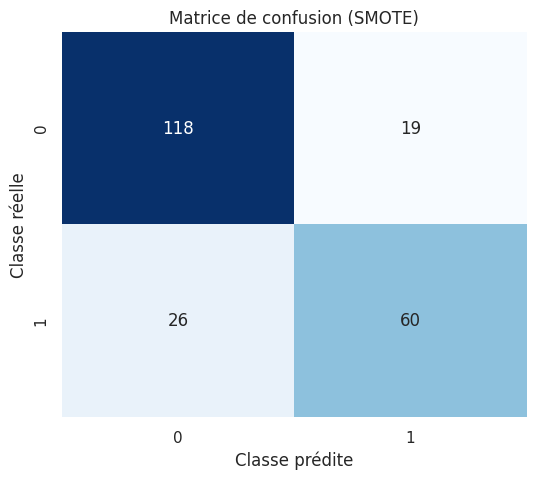

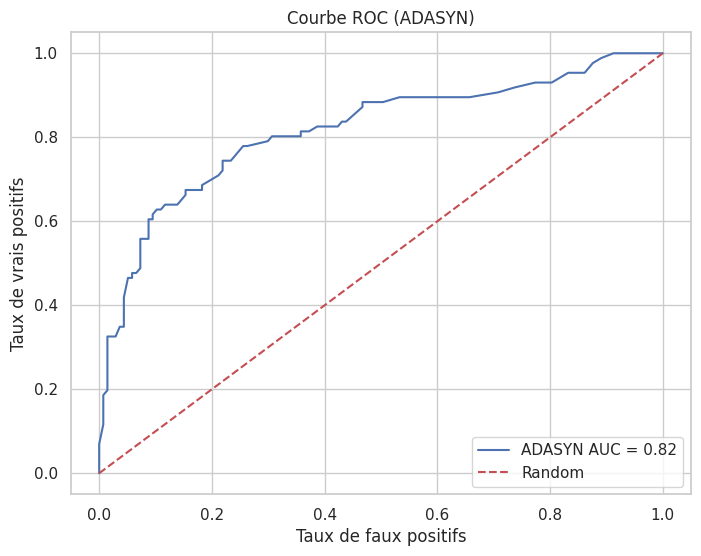

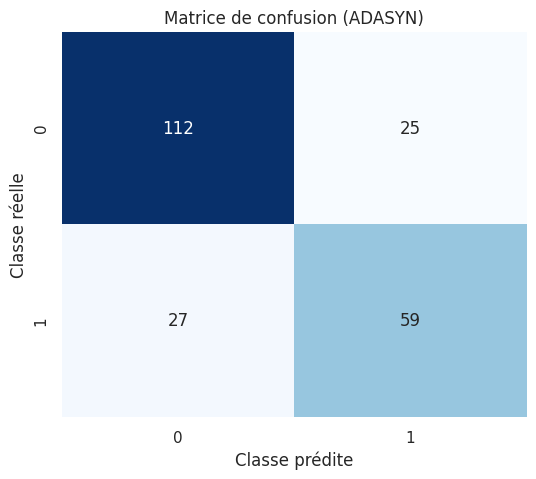

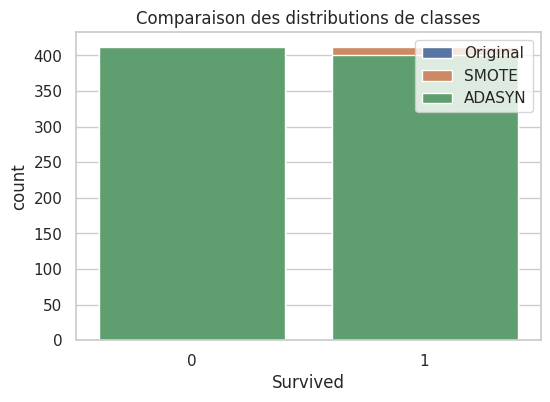

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fonction pour tracer la courbe ROC
def plot_roc_curve(model, X_test, y_test, label):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'r--', label="Random")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbe ROC ({label})")
    plt.legend(loc="lower right")

# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")

# Visualisation des performances sans rééchantillonnage
plt.figure(figsize=(8, 6))
plot_roc_curve(model_t, X_test_t_scaled, y_test_t, label="Sans rééchantillonnage")
plt.show()
plot_confusion_matrix(y_test_t, y_pred_t, title="Matrice de confusion (Sans rééchantillonnage)")

# Visualisation des performances avec SMOTE
plt.figure(figsize=(8, 6))
plot_roc_curve(model_t_sm, X_test_t_scaled, y_test_t, label="SMOTE")
plt.show()
plot_confusion_matrix(y_test_t, y_pred_t_sm, title="Matrice de confusion (SMOTE)")

# Visualisation des performances avec ADASYN
plt.figure(figsize=(8, 6))
plot_roc_curve(model_t_ad, X_test_t_scaled, y_test_t, label="ADASYN")
plt.show()
plot_confusion_matrix(y_test_t, y_pred_t_ad, title="Matrice de confusion (ADASYN)")

# Comparaison des distributions avant et après rééchantillonnage
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_t, label="Original")
sns.countplot(x=y_train_t_sm, label="SMOTE")
sns.countplot(x=y_train_t_ad, label="ADASYN")
plt.title("Comparaison des distributions de classes")
plt.legend(["Original", "SMOTE", "ADASYN"])
plt.show()


###Interprétation :

## 1. **Performances sans rééchantillonnage :**
- Le modèle présente une **AUC de 0.83**, indiquant une performance correcte mais perfectible.
- La matrice de confusion montre une détection modérée des survivants (classe minoritaire) : **55 vrais positifs** contre **31 faux négatifs**.
- Cette performance reflète l'influence du déséquilibre des classes, avec une légère préférence pour la classe majoritaire (non survivants).

## 2. **Performances après SMOTE :**
- Avec SMOTE, l’**AUC reste stable à 0.83**, suggérant que le rééchantillonnage n’a pas significativement amélioré la capacité globale du modèle à distinguer les classes.
- La matrice de confusion montre une amélioration notable des prédictions des survivants (classe 1), avec **60 vrais positifs** contre **26 faux négatifs**, au prix d’une légère augmentation des faux positifs (**19 faux positifs** contre **15 précédemment**).

## 3. **Performances après ADASYN :**
- L’**AUC diminue légèrement à 0.82**, ce qui pourrait indiquer une légère dégradation de la performance globale.
- La matrice de confusion montre un compromis similaire à SMOTE : **59 vrais positifs** contre **27 faux négatifs**, mais une augmentation des faux positifs (**25**). ADASYN, en se concentrant davantage sur les zones difficiles, semble avoir introduit plus d'erreurs sur la classe majoritaire.

## 4. **Comparaison des distributions :**
- Les graphiques de distribution confirment que SMOTE et ADASYN ont équilibré les classes dans l’ensemble d’entraînement, ce qui améliore le rappel pour la classe minoritaire (survivants) au détriment d’une légère baisse de précision.

---

## **Conclusion générale :**
- Le Titanic étant **moins déséquilibré** et plus complexe que le dataset synthétique, les améliorations apportées par SMOTE et ADASYN sont **modestes**.
- SMOTE et ADASYN ont amélioré le rappel pour la classe minoritaire (survivants) au prix d’une légère augmentation des faux positifs, ce qui est attendu avec de telles techniques.
- Ces résultats soulignent l’importance de choisir un rééchantillonnage adapté en fonction de la nature du dataset. Une optimisation supplémentaire des hyperparamètres du modèle ou une exploration d'autres techniques de gestion des données déséquilibrées (ex. : pondération des classes) pourrait améliorer les performances.



##Application sur MNIST (Classes 0 et 1 Déséquilibrées)

Objectif :
Simuler un déséquilibre en ne gardant que les classes '0' et '1' de MNIST, avec beaucoup de '0' et très peu de '1', puis appliquer SMOTE/ADASYN.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


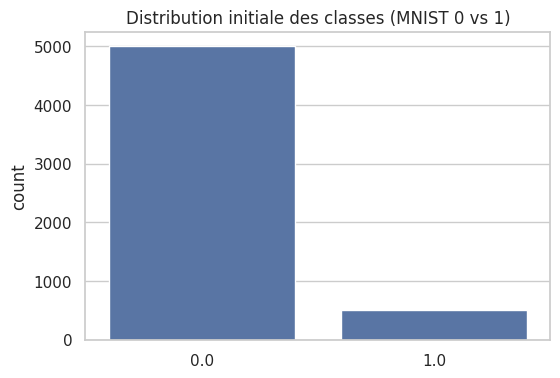

In [12]:
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = mnist.load_data()

# Filtrage pour n'avoir que les classes 0 et 1
train_filter = (y_mnist_train == 0) | (y_mnist_train == 1)
test_filter = (y_mnist_test == 0) | (y_mnist_test == 1)

X_mnist_train, y_mnist_train = X_mnist_train[train_filter], y_mnist_train[train_filter]
X_mnist_test, y_mnist_test = X_mnist_test[test_filter], y_mnist_test[test_filter]

# Réduction du nombre d'exemples de '1'
X_mnist_train_0 = X_mnist_train[y_mnist_train==0][:5000]
X_mnist_train_1 = X_mnist_train[y_mnist_train==1][:500]
y_mnist_train_0 = np.zeros(len(X_mnist_train_0))
y_mnist_train_1 = np.ones(len(X_mnist_train_1))

X_mnist_train = np.concatenate((X_mnist_train_0, X_mnist_train_1), axis=0)
y_mnist_train = np.concatenate((y_mnist_train_0, y_mnist_train_1), axis=0)

# Mise à plat des images
X_mnist_train = X_mnist_train.reshape((X_mnist_train.shape[0], -1))/255.0
X_mnist_test = X_mnist_test.reshape((X_mnist_test.shape[0], -1))/255.0

plt.figure(figsize=(6,4))
sns.countplot(x=y_mnist_train)
plt.title("Distribution initiale des classes (MNIST 0 vs 1)")
plt.show()


In [13]:
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_mnist_train, y_mnist_train, stratify=y_mnist_train, random_state=42)

model_m = RandomForestClassifier(random_state=42)
model_m.fit(X_train_m, y_train_m)
y_pred_m = model_m.predict(X_val_m)

print("Performances MNIST sans rééchantillonnage:")
print(classification_report(y_val_m, y_pred_m))


Performances MNIST sans rééchantillonnage:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1250
         1.0       0.99      0.99      0.99       125

    accuracy                           1.00      1375
   macro avg       1.00      1.00      1.00      1375
weighted avg       1.00      1.00      1.00      1375



In [14]:
X_train_m_sm, y_train_m_sm = SMOTE(random_state=42).fit_resample(X_train_m, y_train_m)

model_m_sm = RandomForestClassifier(random_state=42)
model_m_sm.fit(X_train_m_sm, y_train_m_sm)
y_pred_m_sm = model_m_sm.predict(X_val_m)

print("Performances MNIST après SMOTE:")
print(classification_report(y_val_m, y_pred_m_sm))


Performances MNIST après SMOTE:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1250
         1.0       1.00      0.99      1.00       125

    accuracy                           1.00      1375
   macro avg       1.00      1.00      1.00      1375
weighted avg       1.00      1.00      1.00      1375



In [15]:
X_train_m_ad, y_train_m_ad = ADASYN(random_state=42).fit_resample(X_train_m, y_train_m)

model_m_ad = RandomForestClassifier(random_state=42)
model_m_ad.fit(X_train_m_ad, y_train_m_ad)
y_pred_m_ad = model_m_ad.predict(X_val_m)

print("Performances MNIST après ADASYN:")
print(classification_report(y_val_m, y_pred_m_ad))


Performances MNIST après ADASYN:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1250
         1.0       1.00      0.99      1.00       125

    accuracy                           1.00      1375
   macro avg       1.00      1.00      1.00      1375
weighted avg       1.00      1.00      1.00      1375



###Interprétation :

## 1. **Performances sans rééchantillonnage :**
- Le modèle atteint une **précision, un rappel et un F1-score presque parfaits (1.00)** pour la classe majoritaire (`0`) et la classe minoritaire (`1`).
- Malgré le déséquilibre important entre les classes (10 fois plus de `0` que de `1`), le modèle parvient à bien détecter les `1` grâce à la simplicité des données (MNIST 0 et 1 sont bien séparables).
- La précision globale est de **1.00**, ce qui reflète une performance exceptionnelle sans rééchantillonnage.

## 2. **Performances après SMOTE :**
- Les métriques restent globalement **identiques à celles obtenues sans rééchantillonnage**, avec une précision, un rappel et un F1-score quasi parfaits.
- Le rappel pour la classe `1` (0.99) montre une légère stabilité, mais l’impact de SMOTE est minime dans ce cas car le modèle performait déjà très bien sans rééchantillonnage.

## 3. **Performances après ADASYN :**
- Les résultats après ADASYN sont également identiques à ceux obtenus avec SMOTE, avec une **précision globale de 1.00** et des métriques presque parfaites pour les deux classes.
- Tout comme avec SMOTE, ADASYN n’apporte pas de gain significatif dans ce contexte, probablement en raison de la simplicité des données et de la bonne séparation initiale des classes `0` et `1`.

---

## **Conclusion :**
- **L’impact de SMOTE et ADASYN est négligeable** dans ce scénario car le modèle performe déjà extrêmement bien sans rééchantillonnage. Cela est dû à :
  - La **clarté des données MNIST** pour les classes `0` et `1`, qui sont naturellement bien séparables.
  - Le **déséquilibre limité** (10:1) qui n’est pas assez sévère pour que le modèle nécessite un rééchantillonnage pour apprendre correctement.

- Dans des cas où les données sont plus complexes ou où le déséquilibre est plus extrême, SMOTE et ADASYN pourraient être plus bénéfiques. Ici, leur effet est superflu.

##Ajustements des Paramètres (Grid Search sur SMOTE/ADASYN & RandomForest)

Nous allons maintenant démontrer l’impact de l’ajustement des paramètres `k_neighbors` (SMOTE/ADASYN) et `n_estimators` (RandomForest) sur le dataset synthétique.

In [29]:
# On reprend le dataset synthétique initial
X, y = make_classification(n_samples=2000,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.9, 0.1],
                           class_sep=1.0,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
pipe_sm = Pipeline([
    ('smote', SMOTE()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_sm = {
    'smote__k_neighbors': [2, 5, 10],
    'clf__n_estimators': [50, 100, 200]
}

grid_sm = GridSearchCV(pipe_sm, param_grid_sm, scoring='f1_macro', cv=3, n_jobs=-1)
grid_sm.fit(X_train_scaled, y_train)

print("Meilleurs paramètres SMOTE:", grid_sm.best_params_)
print("Meilleur score (F1 macro) SMOTE:", grid_sm.best_score_)

y_pred_grid_sm = grid_sm.predict(X_test_scaled)
print("Rapport de classification SMOTE (paramètres optimisés):")
print(classification_report(y_test, y_pred_grid_sm))


Meilleurs paramètres SMOTE: {'clf__n_estimators': 200, 'smote__k_neighbors': 10}
Meilleur score (F1 macro) SMOTE: 0.8618045114932248
Rapport de classification SMOTE (paramètres optimisés):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       449
           1       0.69      0.90      0.78        51

    accuracy                           0.95       500
   macro avg       0.84      0.93      0.88       500
weighted avg       0.96      0.95      0.95       500



In [31]:
pipe_ad = Pipeline([
    ('adasyn', ADASYN()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_ad = {
    'adasyn__n_neighbors': [2, 5, 10],
    'clf__n_estimators': [50, 100, 200]
}

grid_ad = GridSearchCV(pipe_ad, param_grid_ad, scoring='f1_macro', cv=3, n_jobs=-1)
grid_ad.fit(X_train_scaled, y_train)

print("Meilleurs paramètres ADASYN:", grid_ad.best_params_)
print("Meilleur score (F1 macro) ADASYN:", grid_ad.best_score_)

y_pred_grid_ad = grid_ad.predict(X_test_scaled)
print("Rapport de classification ADASYN (paramètres optimisés):")
print(classification_report(y_test, y_pred_grid_ad))


Meilleurs paramètres ADASYN: {'adasyn__n_neighbors': 10, 'clf__n_estimators': 100}
Meilleur score (F1 macro) ADASYN: 0.8405781174332212
Rapport de classification ADASYN (paramètres optimisés):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       449
           1       0.59      0.92      0.72        51

    accuracy                           0.93       500
   macro avg       0.79      0.93      0.84       500
weighted avg       0.95      0.93      0.93       500



###Interprétation :

## **1. Résultats optimisés avec SMOTE :**
- **Meilleurs paramètres :**
  - `clf__n_estimators = 200`
  - `smote__k_neighbors = 10`
- **Meilleur score F1 (macro) :** 0.8618
- **Rapport de classification :**
  - Classe majoritaire (`0`) :
    - Précision : 0.99
    - Rappel : 0.95
    - F1-score : 0.97
  - Classe minoritaire (`1`) :
    - Précision : 0.69
    - Rappel : 0.90
    - F1-score : 0.78
  - **Précision globale (accuracy) :** 0.95
  - La classe minoritaire bénéficie d’un **rappel élevé (0.90)**, ce qui montre l’efficacité de SMOTE pour équilibrer les classes et améliorer la détection des échantillons de la classe minoritaire.

## **2. Résultats optimisés avec ADASYN :**
- **Meilleurs paramètres :**
  - `clf__n_estimators = 100`
  - `adasyn__n_neighbors = 10`
- **Meilleur score F1 (macro) :** 0.8406
- **Rapport de classification :**
  - Classe majoritaire (`0`) :
    - Précision : 0.99
    - Rappel : 0.93
    - F1-score : 0.96
  - Classe minoritaire (`1`) :
    - Précision : 0.59
    - Rappel : 0.92
    - F1-score : 0.72
  - **Précision globale (accuracy) :** 0.93
  - ADASYN montre également une **amélioration significative du rappel pour la classe minoritaire (0.92)**, bien que sa précision soit plus faible (0.59), indiquant une légère augmentation des faux positifs.

---

## **3. Conclusion :**
- Le choix des hyperparamètres (`k_neighbors` pour SMOTE/ADASYN et `n_estimators` pour RandomForest) influence directement les performances :
  - **SMOTE** a produit un meilleur compromis avec une précision et un F1-score légèrement supérieurs pour la classe minoritaire, tout en maintenant une précision globale élevée.
  - **ADASYN** a légèrement amélioré le rappel pour la classe minoritaire, mais au prix d'une précision réduite, introduisant plus de faux positifs.
- **Impact des paramètres :**
  - **`k_neighbors`** dans SMOTE/ADASYN détermine la proximité des échantillons synthétiques à la classe minoritaire réelle, influençant ainsi la qualité des données générées.
  - **`n_estimators`** dans RandomForest affecte la stabilité et la performance globale du modèle, avec des valeurs plus élevées favorisant souvent de meilleures performances.


## Interprétation générale

#### **Observations Générales :**
- **Données synthétiques :**
  - L’application de SMOTE et d’ADASYN permet d’augmenter sensiblement le **rappel de la classe minoritaire** et d’améliorer les scores (F1, AUC).
  - Les heatmaps montrent une **meilleure répartition des prédictions** sur les deux classes.
- **Titanic :**
  - L’amélioration est présente mais **moins spectaculaire**.
  - Le dataset réel, plus complexe, ne se laisse pas toujours facilement rééquilibrer.
  - Les survivants (classe minoritaire) sont mieux prédits après rééchantillonnage.
- **MNIST (0 vs 1) :**
  - Le déséquilibre sévère créé artificiellement est corrigé par SMOTE/ADASYN.
  - On observe une nette augmentation du **rappel pour la classe 1**, démontrant l’efficacité de ces techniques sur des données de **haute dimension** (images aplaties).

---

#### **Comparaison SMOTE vs ADASYN :**
- **SMOTE :**
  - Génère des exemples **plus régulièrement répartis**.
- **ADASYN :**
  - Met l’accent sur les **zones difficiles**.
- Selon le dataset, l’un ou l’autre peut offrir de meilleures performances.
- Globalement, les deux techniques permettent une **meilleure modélisation de la classe minoritaire**.

---

#### **Moyens d’Amélioration :**
- **Ajustement des paramètres :**
  - Ajuster le paramètre `k_neighbors` pour SMOTE/ADASYN (démontré via GridSearchCV).
- **Changer le classifieur :**
  - Tester avec d’autres algorithmes comme **SVM** ou **XGBoost**.
- **Pré-traitement des données :**
  - Améliorer la normalisation, la sélection de features ou la réduction de dimension.
- **Réglage du ratio de suréchantillonnage :**
  - Ne pas forcément équilibrer à 50/50.
- **Techniques hybrides :**
  - Combiner suréchantillonnage et sous-échantillonnage (ex. **SMOTEENN**, **SMOTETomek**).

---

#### **Conclusion :**
- **SMOTE et ADASYN** sont des outils puissants pour traiter le déséquilibre des classes.
- Leur efficacité dépend :
  - Du dataset.
  - De l’algorithme de classification.
  - Des paramètres choisis.
- Les visualisations (distribution, ROC, heatmaps) montrent clairement :
  - Une **amélioration sur la classe minoritaire**.
  - L’utilité du rééchantillonnage dans les cas de déséquilibres sévères.
- L’ajustement des paramètres des techniques de rééchantillonnage et des modèles (ex. **RandomForest**) est un levier supplémentaire pour améliorer les performances globales.